# House Prices Prediction using TFDF

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load dataset

In [8]:
train_file_path = "train.csv"
dataset_df = pd.read_csv(train_file_path)
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)
print("Full train dataset shape is {}".format(dataset_df.shape))
dataset_df.head(3)

Full train dataset shape is (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


### Data visualization

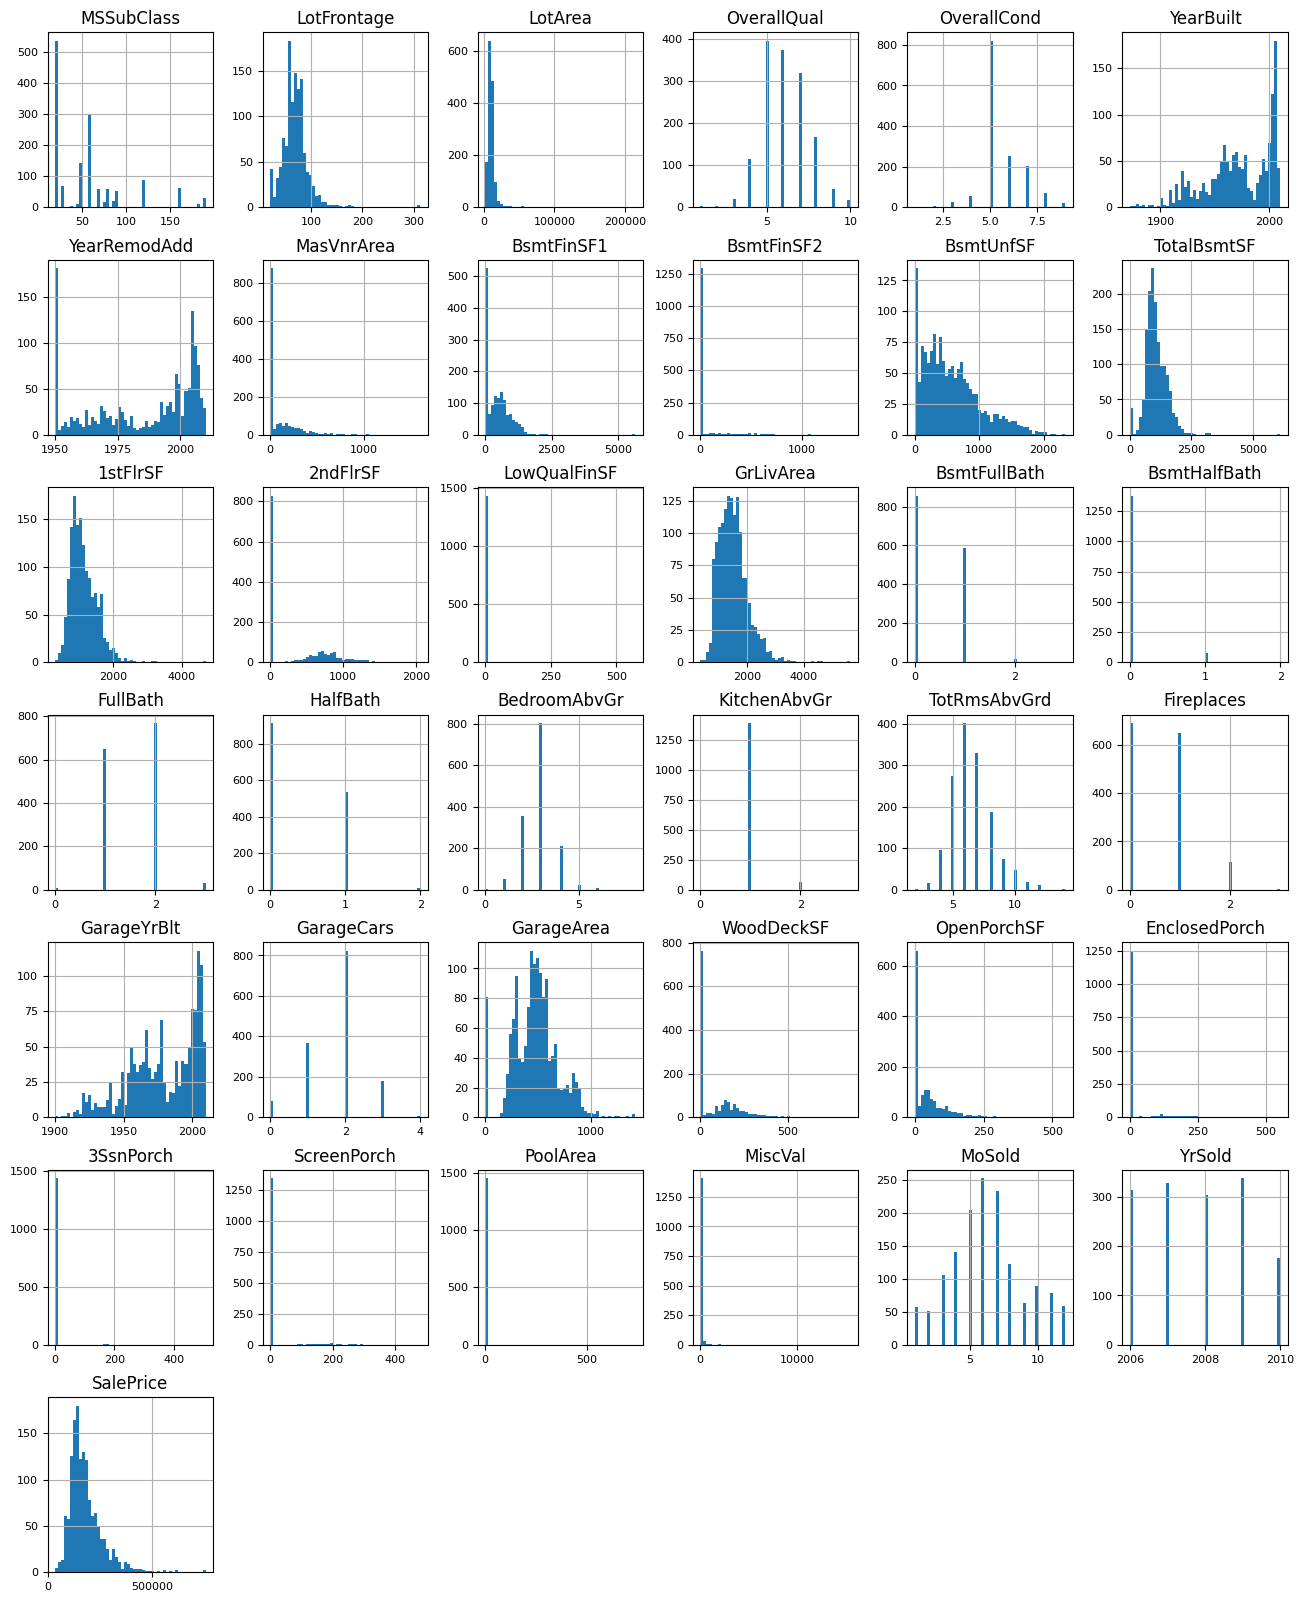

In [18]:
list(set(dataset_df.dtypes.tolist()))
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Prepare dataset

In [15]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

1033 examples in training, 427 examples in testing.


### Train model

In [19]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])
rf.fit(x=train_ds)

Use /var/folders/8_/f7brq0m95px976h8j2mlqdxr0000gn/T/tmpnvsuhk67 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.271505. Found 1033 examples.
Training model...


[INFO 24-10-01 10:36:31.4553 EDT kernel.cc:1233] Loading model from path /var/folders/8_/f7brq0m95px976h8j2mlqdxr0000gn/T/tmpnvsuhk67/model/ with prefix 9a58b6a0ca9e4f28


Model trained in 0:00:03.157740
Compiling model...


[INFO 24-10-01 10:36:32.0869 EDT decision_forest.cc:734] Model loaded with 300 root(s), 98166 node(s), and 75 input feature(s).
[INFO 24-10-01 10:36:32.0869 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-10-01 10:36:32.0870 EDT kernel.cc:1061] Use fast generic engine


Model compiled.


In [20]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

### Evaluate the model on the Out of bag (OOB) data and the validation dataset

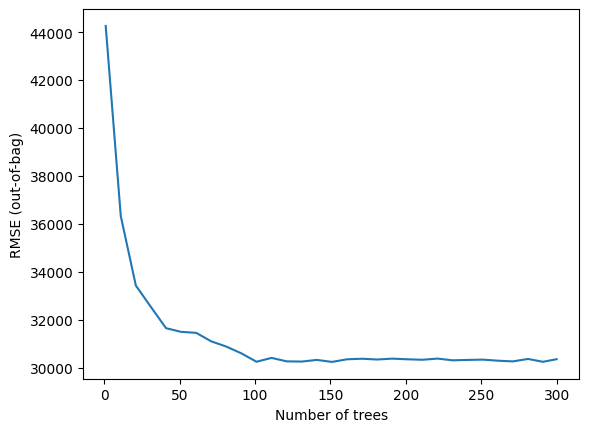

In [21]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [24]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 583ms/step - loss: 0.0000e+00 - mse: 665667712.0000
loss: 0.0000
mse: 665667712.0000


### Variable importances

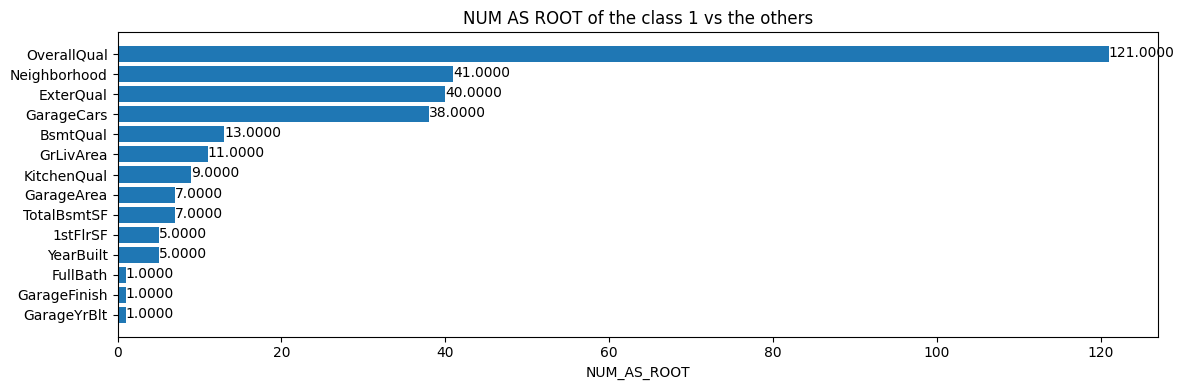

In [25]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

### Predict on test dataset

In [26]:
test_file_path = "test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 2s 47ms/step


,Id,SalePrice
0,1461,125500.804688
1,1462,155998.062500
2,1463,180933.625000
3,1464,184391.375000
4,1465,199541.828125


In [28]:
sample_submission_df = pd.read_csv('sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.head()

2/2 [==============================] - 1s 55ms/step


,Id,SalePrice
0,1461,125500.804688
1,1462,155998.062500
2,1463,180933.625000
3,1464,184391.375000
4,1465,199541.828125
